In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.insert(1, os.path.join(sys.path[0], '.'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import pandas as pd
import seaborn as sns

from src import data
from datetime import date
from io import StringIO


# Load Data

In [135]:
orders = StringIO("""
asset,order_date,unit_cost_usd,order_units,order_cost_usd
COST,2021-04-06T09:30:01,360.12,2,720.24
COST,2021-04-09T09:30:01,363.21,1,363.21
COST,2021-04-13T09:30:02,365.21,3,1095.63
COUR,2021-04-05T09:31:01,49.61,16,793.76
DHR,2021-04-09T09:30:00,232.36,5,1161.8
DHR,2021-04-13T09:30:00,242.84,6,1457.04
SOXX,2021-04-09T09:30:02,446.8,2,893.6
SOXX,2021-04-13T09:30:01,441.3,3,1323.9
""")
orders_df = (
  pd
    .read_csv(orders, parse_dates = ['order_date'])
    .reset_index()
    .rename(columns = {'index': 'order_id'})
    .assign(
      order_id = lambda df: df['order_id']+1,
      order_date = lambda df: pd.to_datetime(df['order_date'].dt.date)
    )
)
orders_df

,order_id,asset,order_date,unit_cost_usd,order_units,order_cost_usd
0,1,COST,2021-04-06,360.12,2,720.24
1,2,COST,2021-04-09,363.21,1,363.21
2,3,COST,2021-04-13,365.21,3,1095.63
3,4,COUR,2021-04-05,49.61,16,793.76
4,5,DHR,2021-04-09,232.36,5,1161.80
5,6,DHR,2021-04-13,242.84,6,1457.04
6,7,SOXX,2021-04-09,446.80,2,893.60
7,8,SOXX,2021-04-13,441.30,3,1323.90


In [137]:
# orders = [
#   #COST	2021-04-06, 09:30:01	360.12	2	720.24
#   {
#     'asset': 'COST',
#     'order_date': date(2021, 4, 6),
#     'order_id': 1,
#     'order_units': 2,
#     'unit_cost_usd': 360.12,
#   },
# ]

In [138]:
# orders_df = data.make_orders_df(orders)
assets = list(orders_df['asset'].unique())
prices_df = data.make_prices_df(assets)

[*********************100%***********************]  4 of 4 completed


/Users/calvindelima/projects/investing/.venv/lib/python3.9/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [139]:
order_value_snapshot_df = data.make_order_value_snapshot_df(
  prices_df,
  orders_df
)
asset_value_snapshot_df = data.make_asset_value_snapshot_df(
  order_value_snapshot_df
)
portfolio_value_snapshot_df = data.make_portfolio_value_snapshot_df(
  asset_value_snapshot_df
)

In [141]:
orders_df

,order_id,asset,order_date,unit_cost_usd,order_units,order_cost_usd
0,1,COST,2021-04-06,360.12,2,720.24
1,2,COST,2021-04-09,363.21,1,363.21
2,3,COST,2021-04-13,365.21,3,1095.63
3,4,COUR,2021-04-05,49.61,16,793.76
4,5,DHR,2021-04-09,232.36,5,1161.80
5,6,DHR,2021-04-13,242.84,6,1457.04
6,7,SOXX,2021-04-09,446.80,2,893.60
7,8,SOXX,2021-04-13,441.30,3,1323.90


In [142]:
prices_df.tail(5)

,price_date,asset,unit_price_usd
42679,2021-04-19,SOXX,434.250000
42680,2021-04-20,SOXX,426.300003
42681,2021-04-21,SOXX,429.664993
42682,2021-04-22,SOXX,429.875000
42683,2021-04-23,SOXX,430.339996


In [143]:
order_value_snapshot_df

,asset,price_date,order_date,order_id,order_units,unit_price_usd,order_cost_usd,order_value_usd
31971,COST,2021-04-06,2021-04-06,1,2,359.959991,720.24,719.919983
31974,COST,2021-04-07,2021-04-06,1,2,359.839996,720.24,719.679993
31977,COST,2021-04-08,2021-04-06,1,2,362.009995,720.24,724.019989
31980,COST,2021-04-09,2021-04-06,1,2,362.059998,720.24,724.119995
31981,COST,2021-04-09,2021-04-09,2,1,362.059998,363.21,362.059998
...,...,...,...,...,...,...,...,...
85363,SOXX,2021-04-21,2021-04-13,8,3,429.664993,1323.90,1288.994980
85364,SOXX,2021-04-22,2021-04-09,7,2,429.875000,893.60,859.750000
85365,SOXX,2021-04-22,2021-04-13,8,3,429.875000,1323.90,1289.625000
85366,SOXX,2021-04-23,2021-04-09,7,2,430.339996,893.60,860.679993


<ipython-input-144-b1c77f89d5a3>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


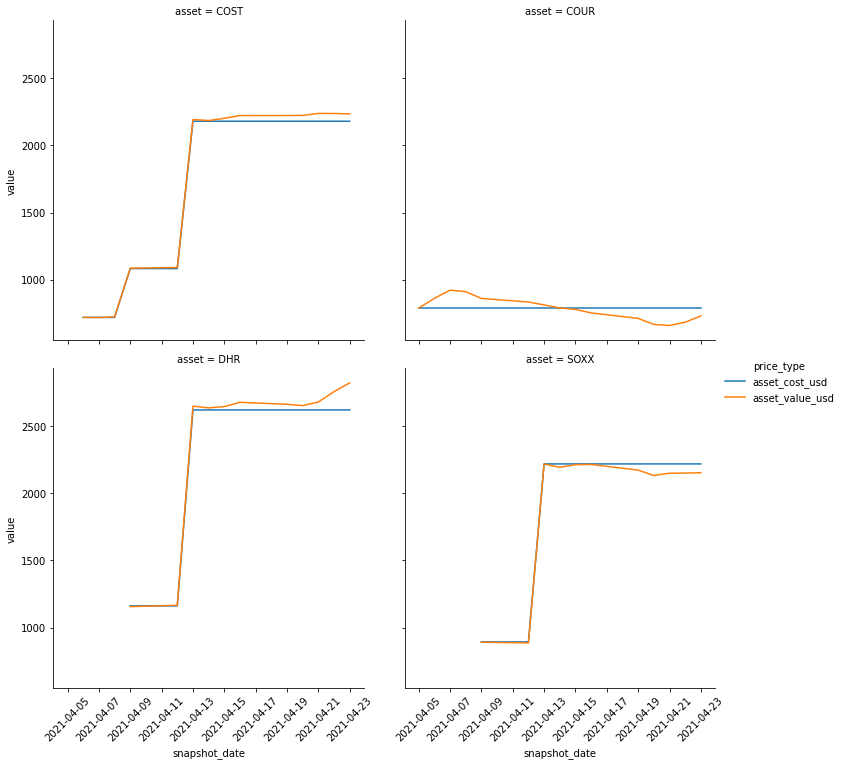

In [144]:
plot_df = (
  asset_value_snapshot_df
    .melt(
      id_vars = ['asset', 'snapshot_date'],
      var_name = 'price_type'
    )
)

# plot_df

g = sns.relplot(
  data = plot_df,
  col = 'asset',
  col_wrap = 2,
  x = 'snapshot_date',
  y = 'value',
  hue = 'price_type',
  kind = 'line'
);

for ax in g.axes.ravel():
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [149]:
orders_df.query('asset == "COST"')

,order_id,asset,order_date,unit_cost_usd,order_units,order_cost_usd
0,1,COST,2021-04-06,360.12,2,720.24
1,2,COST,2021-04-09,363.21,1,363.21
2,3,COST,2021-04-13,365.21,3,1095.63


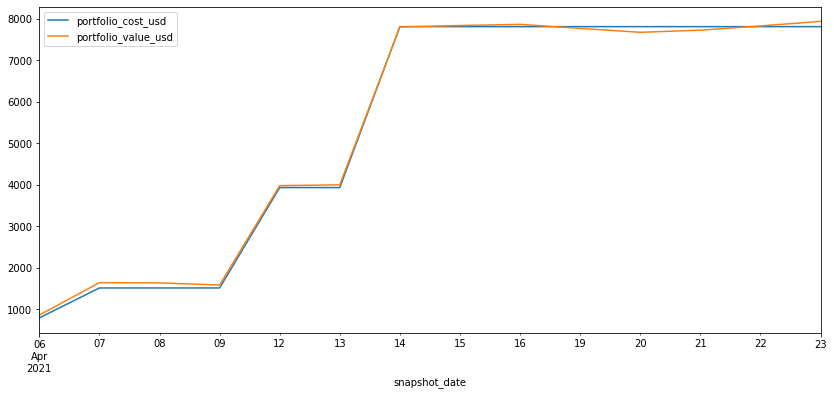

In [108]:
(
  portfolio_value_snapshot_df
    .set_index('snapshot_date')
    .plot(figsize = (14, 6))
);

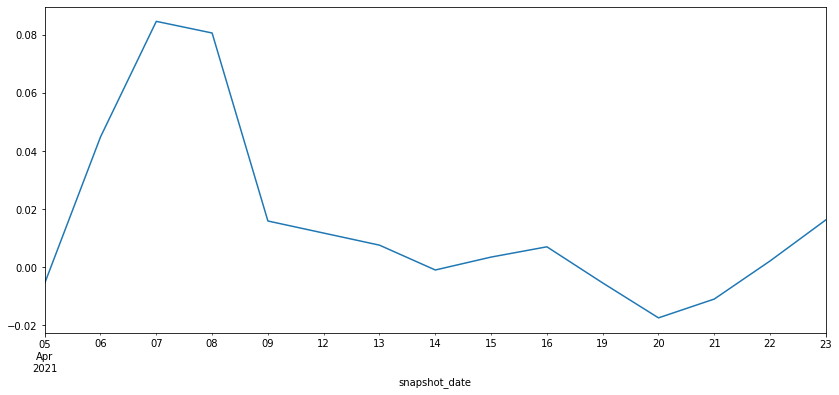

In [179]:
(
  portfolio_value_snapshot_df
    .set_index('snapshot_date')
    .assign(percent_return = lambda df: df['portfolio_value_usd'] / df['portfolio_cost_usd'] - 1)
    ['percent_return']
    .plot(figsize = (14, 6))
);

In [111]:
portfolio_value_snapshot_df.tail(1)

,snapshot_date,portfolio_cost_usd,portfolio_value_usd
13,2021-04-23,7809.18,7936.325012


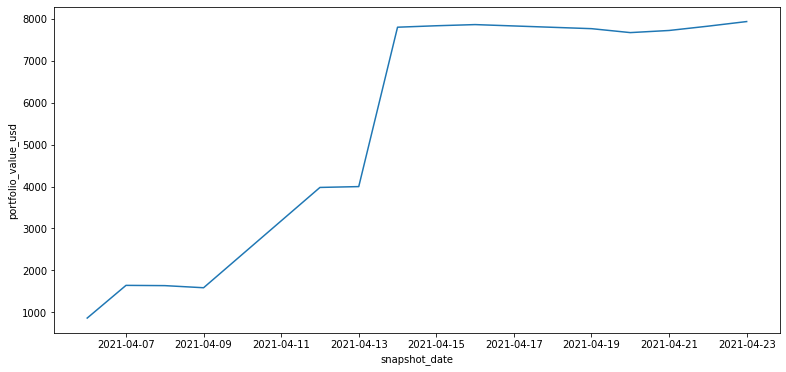

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 6))
l = portfolio_value_snapshot_df[['snapshot_date', 'portfolio_value_usd']]
sns.lineplot(x = 'snapshot_date', y = 'portfolio_value_usd', data = l);

In [174]:
portfolio_return_series = (
  portfolio_value_snapshot_df
    .assign(
      percent_return = lambda df: df['portfolio_value_usd'] / df['portfolio_cost_usd'] - 1
    )
    .set_index('snapshot_date')
    ['percent_return']
)
# portfolio_return_series

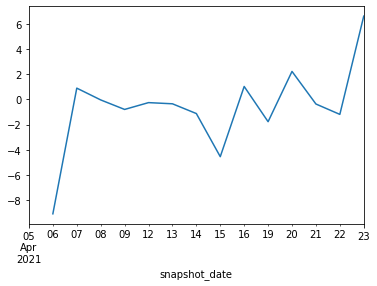

In [172]:
portfolio_return_series.pct_change().plot();